#**3. Training a model to recognize sentiment in text**

Here, we will build a classifier to recognize the sentiment of the text.

We'll be analyzing a title is sarcastic not.

Imports and initializations

In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

--2022-04-02 20:03:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2022-04-02 20:03:47 (146 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences) #creating tokens with every word of the corpus
word_index = tokenizer.word_index #saving them in the word index

sequences = tokenizer.texts_to_sequences(sentences) #turning sentence into sequences of tokens
padded = pad_sequences(sequences,padding='post') #padding the tokens to the max sequence number
print(padded[0])
print(padded.shape)

[  308 15115   679  3337  2298    48   382  2576 15116     6  2577  8434
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
(26709, 40)


To split this data into training and test sets, We do this

In [4]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

But we want to ensure the NN only sees the training data and never sees the test data.

So, We have to rewrite our code to  ensure the tokenizer only fits the training data. The new code to create training and test sets are

In [5]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok) #Instanciating a tokenizer
tokenizer.fit_on_texts(training_sentences) #Fitting the tokenizer only in training sentences instead of the entire corpus

word_index = tokenizer.word_index 

#Now, instead of one overall sequences, We can now create a set of training sequences and a set of testing sequences

training_sequences = tokenizer.texts_to_sequences(training_sentences )
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Recalling the **word embedding** concept

In natural language processing, word embedding is a term used for the representation of words that are close in meaning are grouped near to one another in vector space for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning.

What if a label with sentiment like "sarcastic" or "not sarcastic" are plotted in these multiple dimensions and we train and try to learn what the directions are in these multi-dimentional spaces should look like.

Words that only appear in the sarcastic sentences will have a strong component in the sarcastic directions and others will have in the not sarcastic direction.

As we load more and more sentences into the training, these direction can change. After haing a fully trained network and after giving it a set of words, It could look up the vectors of this words, sum them up and thus give us an idea of the sentiment.

Note: The order in which the words appear doesn't really matter

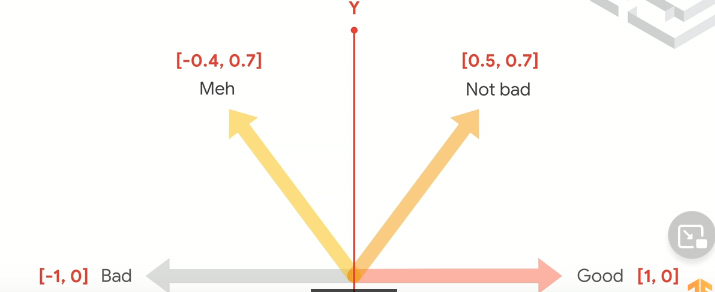


Let's code this thing.

Defining, Compiling & Training the model

In [6]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_epochs = 30 #num_epochs = 30 
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 4s - loss: 0.6620 - accuracy: 0.5891 - val_loss: 0.5700 - val_accuracy: 0.7248 - 4s/epoch - 6ms/step
Epoch 2/30
625/625 - 2s - loss: 0.4222 - accuracy: 0.8331 - val_loss: 0.3863 - val_accuracy: 0.8313 - 2s/epoch - 3ms/step
Epoch 3/30
625/625 - 2s - loss: 0.3049 - accuracy: 0.8788 - val_loss: 0.3489 - val_accuracy: 0.8538 - 2s/epoch - 3ms/step
Epoch 4/30
625/625 - 2s - loss: 0.2527 - accuracy: 0.9009 - val_loss: 0.3431 - val_accuracy: 0.8538 - 2s/epoch - 3ms/step
Epoch 5/30
625/625 - 2s - loss: 0.2175 - accuracy: 0.9154 - val_loss: 0.3434 - val_accuracy: 0.8545 - 2s/epoch - 3ms/step
Epoch 6/30
625/625 - 2s - loss: 0.1899 - accuracy: 0.9270 - val_loss: 0.3523 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 7/30
625/625 - 2s - loss: 0.1694 - accuracy: 0.9362 - val_loss: 0.3660 - val_accuracy: 0.8547 - 2s/epoch - 3ms/step
Epoch 8/30
625/625 - 2s - loss: 0.1500 - accuracy: 0.9445 - val_loss: 0.4047 - val_accuracy: 0.8405 - 2s/epoch - 3ms/step
Epoch 9/30
625/625 - 2s 

In [9]:
sentence = ["granny starting to fear spiders in the garden might be real", #A bit sarcastic
"the weather today is bright and sunny"] #Plain and boring

sequences = tokenizer.texts_to_sequences(sentence)

padded = pad_sequences(sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)

print(model.predict(padded))

print("Note: This is the probability of a sentence being a sarcasm")

[[9.9316967e-01]
 [2.3563733e-05]]
Note: This is the probability of a sentence being a sarcasm


Result comparison

In [ ]:
Video                 : [[9.103e-01], [5.06e-06]]       #Very likely & Likely not
Videos linked colab   : [[0.3990895], [0.42568198]]     #Not very likely & Likely not
My result: (Epoch=1)  : [[0.42544192],[0.30547404]]     #Not likely & Likely not
My result: (Epoch=30)  : [[0.9930],[0.0.0230]]          #Very very likely & very very unlikely